# Lab5 - More Bayesian Modeling

# ❗❗❗ Very important administrative detail

The lab changes its content once every **TWO WEEKS**.

*   week 1 & week 2 - lab1
*   week 3 & week 4 - lab2
*   week 5 & week 6 - lab3
*   week 7 & week 8 - lab4
*   week 9 & week 10 - lab5
* ...

# From German tanks to locomotives

Open the bayesian modeling lecture (Lecture 5) and re-read the german tank problem.

Replacing German tanks with locomotives bring on a similar problem: a railroad numbers its locomotives in order 1..N and the locomotives with the numbers 10, 256, 202 and 97 were observed, estimate how many locomotives the railroad has. But this time you have more background information. It is probably not reasonable to assume that a train-operating company with 1000 locomotives is just as likely as a company with only 1 (as we assumed in the uniform prior for N).

In most fields, there are many small companies, fewer medium-sized companies, and only one or two very large companies. In fact, the distribution of company sizes tends to follow a power law. This law suggests that if there are 1000 companies with fewer than 10 locomotives, there might be 100 companies with 100 locomotives, 10 companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a given size is inversely proportional to size, or

PMF$(x) = \frac{1}{x^{\alpha}}$

where PMF$(x)$ is the probability mass function of $x$ and $\alpha$ is a parameter that is often near 1.

Using PyMC, estimate N in this situation.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import seaborn as sns
import pytensor.tensor as pt

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [ ]:
D = np.array([10, 256, 202, 97])
alpha = 1.0

N_min = D.max()
N_max = 30000
N_max_v = np.arange(N_min, N_max+1).astype(int)

p_N = 1 / N_max_v**alpha
p_N = p_N / p_N.sum()
p_N

array([8.19651272e-04, 8.16461967e-04, 8.13297386e-04, ...,
       6.99482384e-06, 6.99459067e-06, 6.99435752e-06])

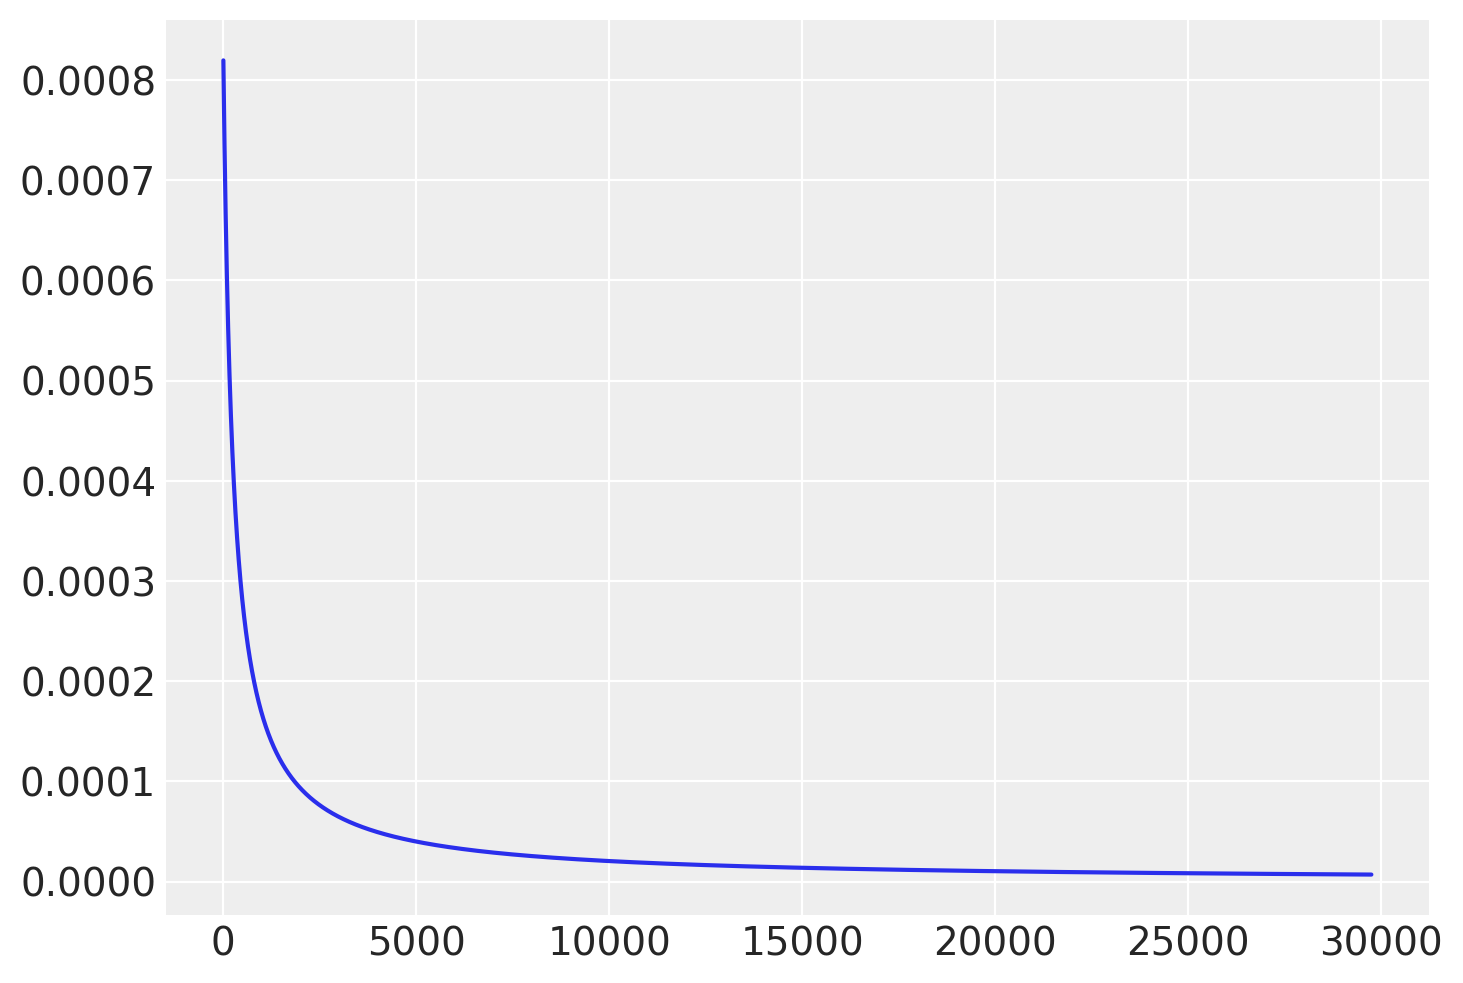

In [ ]:
plt.plot(p_N)
plt.show()

Output()

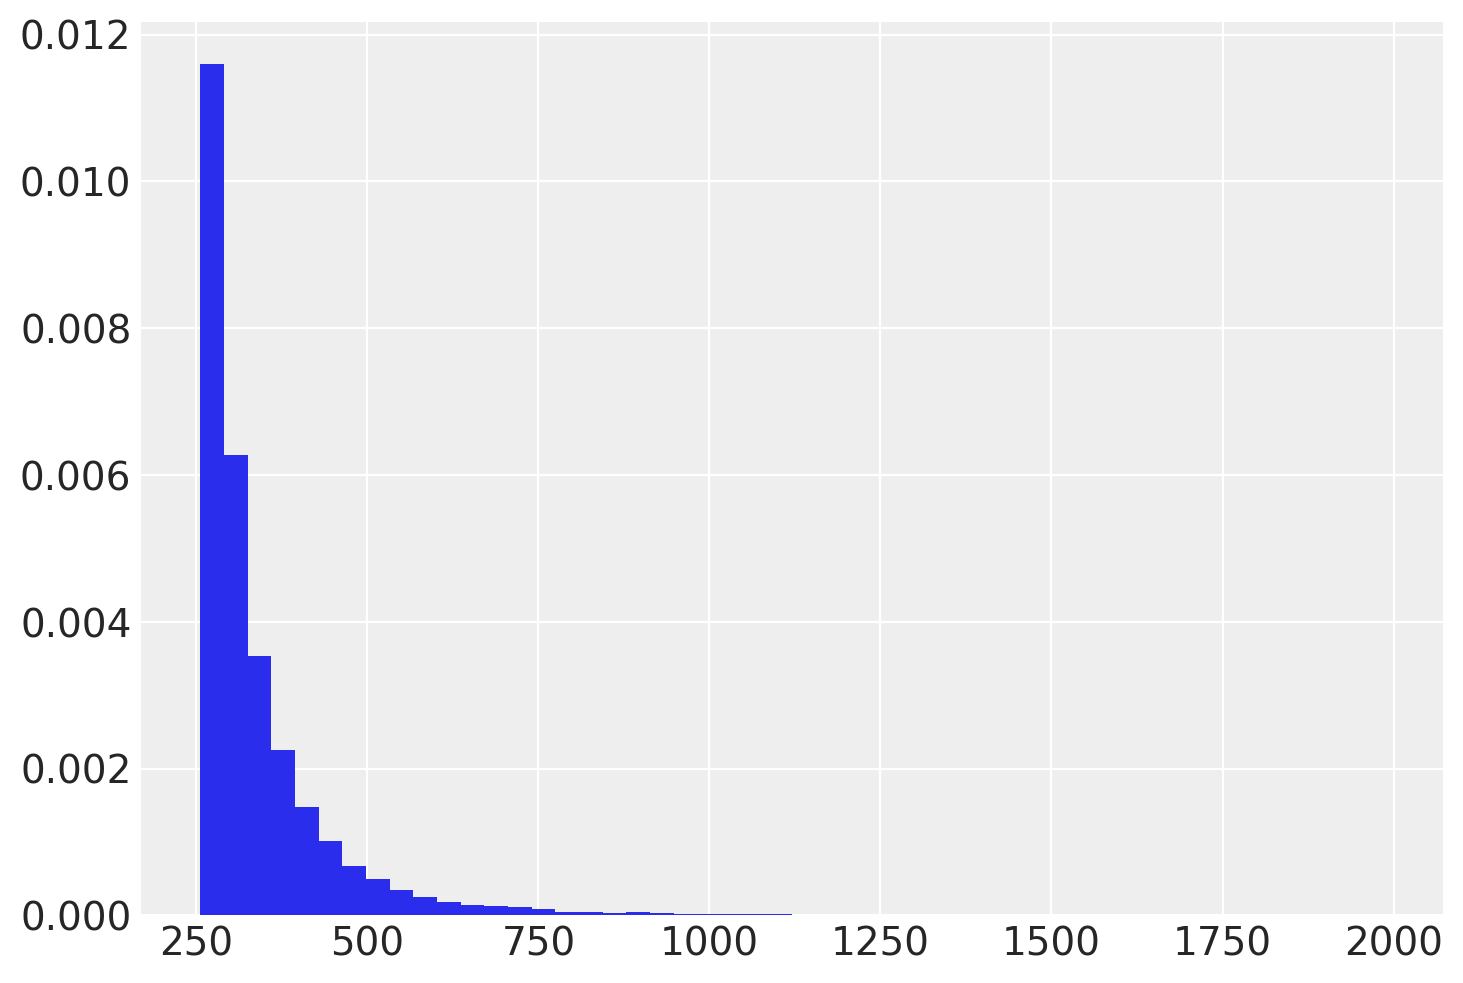

In [ ]:
with pm.Model() as model:

    possible_max_production = pm.Categorical("possible_max_production", p=p_N)
    N_max_v = pt.as_tensor_variable(N_max_v)
    N = pm.Deterministic("N", N_max_v[possible_max_production])

    obs = pm.DiscreteUniform("obs", lower=1, upper=N, observed=D)

    step = pm.Metropolis()
    trace = pm.sample(40000, tune=10000, chains=1, step=step, return_inferencedata=False)

N_samples = trace["N"]

plt.hist(N_samples, bins=50, density=True)
plt.show()

# Case study
Open https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html and read the study on estimating the comparisons between two groups.

Can we use a Normal instead of StudentT? Implement in PyMC the change from StudentT to Normal and compare your results with the official ones.

In [ ]:
import arviz as az
import numpy as np
import pymc as pm
import xarray as xr
import matplotlib.pyplot as plt


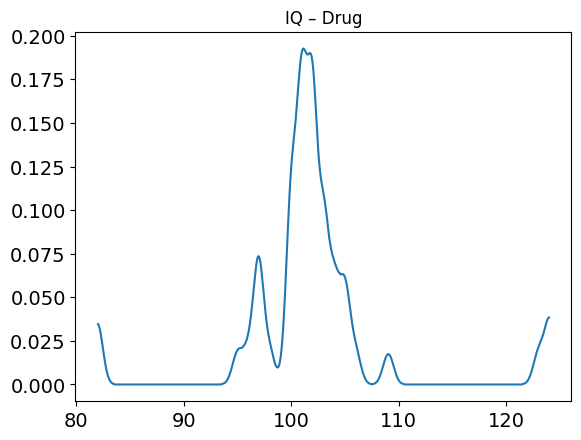

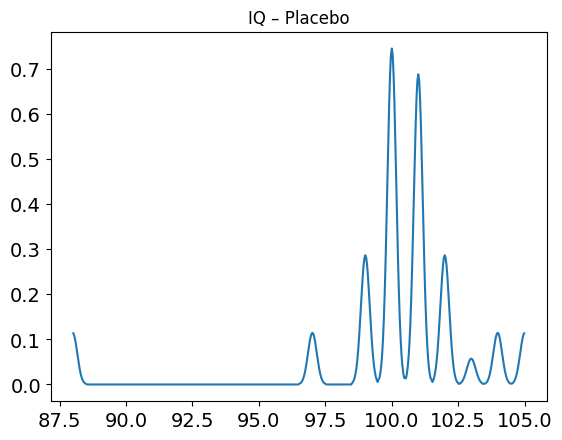

In [ ]:
# fmt: off
iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103,
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
    101, 101, 104, 100, 101
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])
# fmt: on
dt = xr.Dataset({"iq_drug": (["drug"], iq_drug), "iq_placebo": (["placebo"], iq_placebo)})

az.plot_dist(iq_drug, kind="kde")
plt.title("IQ – Drug")
plt.show()

# Placebo group
az.plot_dist(iq_placebo, kind="kde")
plt.title("IQ – Placebo")
plt.show()

In [ ]:
mu_data=dt.to_array().mean().item()
std_data=dt.to_array().std().item()*2

In [ ]:
with pm.Model() as modelNormal:
  mu_gr1=pm.Normal("mu_group1",mu=mu_data, sigma=std_data)
  mu_gr2=pm.Normal("mu_group2",mu=mu_data, sigma=std_data)

  std_gr1=pm.HalfNormal("std_group1", sigma=10)
  std_gr2=pm.HalfNormal("std_group2", sigma=10)

  likelihood_gr1=pm.Normal("drug", mu=mu_gr1, sigma=std_gr1)
  likelihood_gr2=pm.Normal("placebo", mu=mu_gr2, sigma=std_gr2)

  #measuring diff in mean/var and effect of drug
  diff_of_means = pm.Deterministic("difference of means", mu_gr1 - mu_gr2)
  diff_of_stds = pm.Deterministic("difference of stds", std_gr1 - std_gr2)
  effect_size = pm.Deterministic(
      "effect_size",
      diff_of_means / pm.math.sqrt((std_gr1**2 + std_gr2**2) / 2)
  )
  trace = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.99)


Output()

ERROR:pymc.stats.convergence:There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'mu_group1'}>,
        <Axes: title={'center': 'mu_group1'}>],
       [<Axes: title={'center': 'mu_group2'}>,
        <Axes: title={'center': 'mu_group2'}>],
       [<Axes: title={'center': 'std_group1'}>,
        <Axes: title={'center': 'std_group1'}>],
       [<Axes: title={'center': 'std_group2'}>,
        <Axes: title={'center': 'std_group2'}>]], dtype=object)

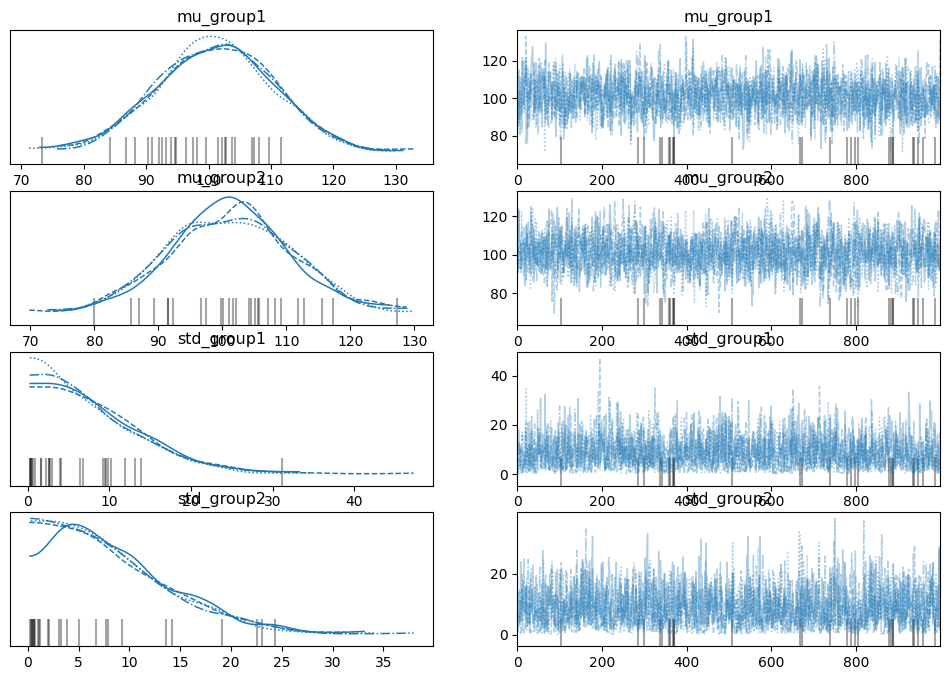

In [ ]:
az.plot_trace(trace, var_names=["mu_group1", "mu_group2", "std_group1", "std_group2"])

array([[<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}>],
       [<Axes: title={'center': 'effect_size'}>,
        <Axes: title={'center': 'effect_size'}>]], dtype=object)

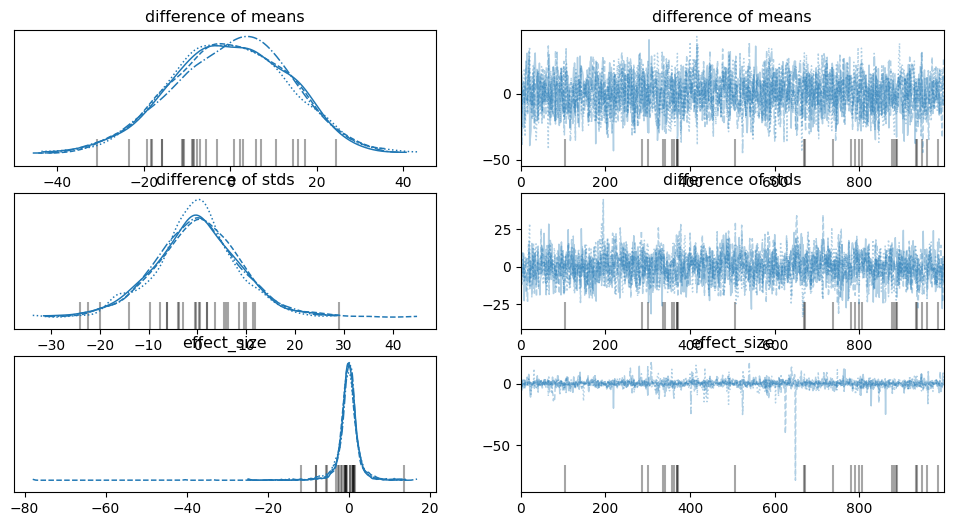

In [ ]:
az.plot_trace(
    trace,
    var_names=["difference of means", "difference of stds", "effect_size"]
)


In [ ]:
with pm.Model() as modelStudentT:
    mu_gr1 = pm.Normal("mu_group1", mu=mu_data, sigma=std_data)
    mu_gr2 = pm.Normal("mu_group2", mu=mu_data, sigma=std_data)

    std_gr1 = pm.HalfNormal("std_group1", sigma=10)
    std_gr2 = pm.HalfNormal("std_group2", sigma=10)

    nu = pm.Exponential("nu_minus_one", 1/29) + 1  # robust heavy-tailed

    likelihood_gr1 = pm.StudentT("drug", nu=nu, mu=mu_gr1, sigma=std_gr1, observed=iq_drug)
    likelihood_gr2 = pm.StudentT("placebo", nu=nu, mu=mu_gr2, sigma=std_gr2, observed=iq_placebo)

    diff_of_means = pm.Deterministic("difference of means", mu_gr1 - mu_gr2)
    diff_of_stds = pm.Deterministic("difference of stds", std_gr1 - std_gr2)
    effect_size = pm.Deterministic(
        "effect_size",
        diff_of_means / pm.math.sqrt((std_gr1**2 + std_gr2**2) / 2)
    )

    trace = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.99)


Output()

array([[<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}>],
       [<Axes: title={'center': 'effect_size'}>,
        <Axes: title={'center': 'effect_size'}>]], dtype=object)

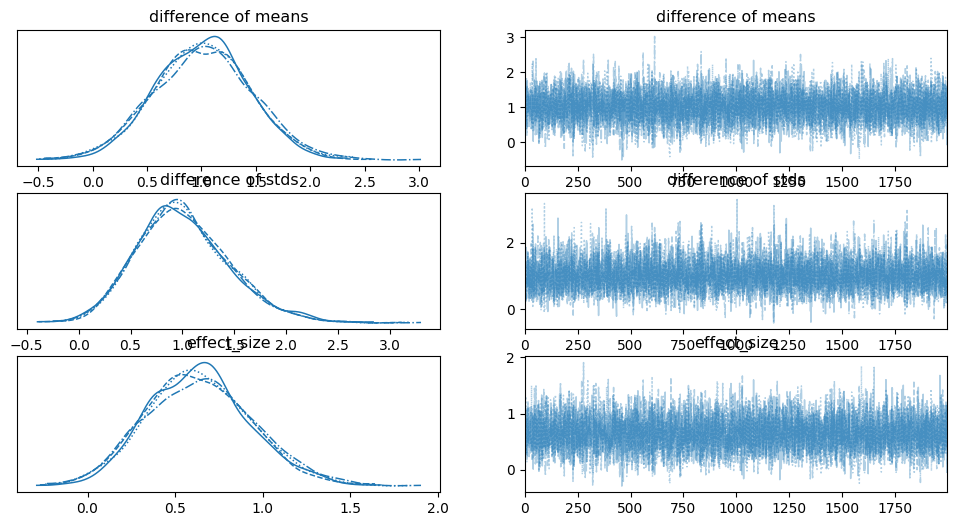

In [ ]:
az.plot_trace(
    trace,
    var_names=["difference of means", "difference of stds", "effect_size"]
)


## Conclusion:
- we cannot use NormalDistr for this problem as it is too sensitive to outliers(very high/low values of IQ)
- mean/var dont converge and effect size has very high variance (around 40)
- using a heavy-tailed Student-t likelihood handles extreme IQ values better